In [1]:
import random as rd
from collections import defaultdict
import numpy as np

In [2]:
with open("data/test15.txt") as f:
    lines = f.readlines()

In [3]:
ncourse = int(lines[0].split()[0])
nroom = int(lines[0].split()[1])
npopulation = 50
crossover_rate = 0.8
mutate_rate = 0.75
nmutate = 8
nelite = 8
ntournament = 15

In [4]:
class Course:
    def __init__(self, code, nlesson, teacher, capacity):
        self.code = code
        self.nlesson = nlesson
        self.teacher = teacher
        self.capacity = capacity
        
    def __str__(self):
        return f"{self.code}"

In [5]:
class Room:
    def __init__(self, code, capacity):
        self.code = code
        self.capacity = capacity
        
    def __str__(self):
        return f"{self.code}"

In [6]:
class Schedule:
    def __init__(self, timetable, usedtime):
        self.timetable = timetable
        self.usedtime = usedtime
        
    def fitness(self):
        error = 0
        check = {}
        for [day, lesson, room, course] in self.timetable:
            if course.capacity > room.capacity:
                error += 1
            if (day, lesson, room) in check.keys():
                error += 1
            else:
                check[(day, lesson, room)] = 1
            if (day, lesson, course.teacher) in check.keys():
                error += 1
            else:
                check[(day, lesson, course.teacher)] = 1
            if (day, lesson, course) in check.keys():
                error += 1
            else:
                check[(day, lesson, course)] = 1
        fitness = 1.0 / (error + 1)
        return fitness
    
    def statistic(self):
        days = defaultdict(int)
        lessons = defaultdict(int)
        rooms = defaultdict(int)
        for [day, lesson, room, course] in self.timetable:
            rooms[room.code] += 1
            lessons[lesson] += 1
            days[day] += 1
        pdays = [len(self.timetable) / days[i] if days[i] != 0 else 0 for i in range(2, 7)]
        ps = sum(pdays)
        pdays = [pday / ps for pday in pdays]
        plessons = [len(self.timetable) / lessons[i] if lessons[i] != 0 else 0 for i in range(1, 13)]
        pl = sum(plessons)
        plessons = [plesson / pl for plesson in plessons]
        prooms = [len(self.timetable) / rooms[i] if rooms[i] != 0 else 0 for i in range(0, nroom)]
        pr = sum(prooms)
        prooms = [proom / pr for proom in prooms]
        return (pdays, plessons, prooms)
    
    def errors(self):
        capacity_error = room_error = teacher_error = course_error = 0
        check = {}
        for [day, lesson, room, course] in self.timetable:
            if course.capacity > room.capacity:
                capacity_error += 1
            if (day, lesson, room) in check.keys():
                room_error += 1
            else:
                check[(day, lesson, room)] = 1
            if (day, lesson, course.teacher) in check.keys():
                teacher_error += 1
            else:
                check[(day, lesson, course.teacher)] = 1
            if (day, lesson, course) in check.keys():
                course_error += 1
            else:
                check[(day, lesson, course)] = 1
        return [capacity_error, room_error, teacher_error, course_error]

In [7]:
def random_course(data):
    courses = []
    cnt = 0
    for row in data:
        row = row.split()
        courses.append(
            Course(cnt, int(row[0]), int(row[1]), int(row[2]))
        )
        cnt += 1
    return courses

courses = random_course(lines[1:ncourse])

def random_room(data):
    rooms = []
    cnt = 0
    for row in data:
        row = row.split()
        rooms.append(
            Room(cnt, int(row[0]))
        )
        cnt += 1
    return rooms

rooms = random_room(lines[1 + ncourse:])

In [8]:
def init_schedule():
    timetable = []
    usedtime = defaultdict(int)
    for course in courses:
        for _ in range(course.nlesson):
            element = [
                rd.randint(2, 6), 
                rd.randint(1, 12), 
                rooms[rd.randint(0, nroom - 1)], 
                course
            ]
            timetable.append(element)
            usedtime[(element[0], element[1], element[2])] += 1
    return Schedule(timetable, usedtime)

def init_population(npopulation):
    populations = []
    for _ in range(npopulation):
        schedule = init_schedule()
        populations.append(schedule)
    return populations

In [9]:
def crossover(populations):
    populations = sorted(populations, key=lambda schedule: schedule.fitness(), reverse=True)
    for schedule in populations[nelite:]:
        # timetable = schedule.timetable
        if crossover_rate > rd.random():
            tournament_01 = init_population(ntournament)
            tournament_01 = sorted(tournament_01, key=lambda schedule: schedule.fitness(), reverse=True)
            timetable_01 = tournament_01[0].timetable
            tournament_02 = init_population(ntournament)
            tournament_02 = sorted(tournament_02, key=lambda schedule: schedule.fitness(), reverse=True)
            timetable_02 = tournament_02[0].timetable
            timetable = [timetable_01[i] if timetable_01[i][2].capacity >= timetable_01[i][3].capacity else timetable_02[i] for i in range(len(schedule.timetable))]
            usedtime = defaultdict(int)
            for element in timetable:
                if element[2].capacity < element[3].capacity:
                    while True:
                        room = rooms[rd.randint(0, nroom - 1)]
                        if room.capacity >= element[3].capacity:
                            element[2] = room
                            break
                usedtime[(element[0], element[1], element[2])] += 1
            schedule.timetable = timetable
            schedule.usedtime = usedtime
    return populations

In [10]:
def mutate(populations):
    populations = sorted(populations, key=lambda schedule: schedule.fitness(), reverse=True)
    for schedule in populations[nelite:]:
        if mutate_rate > rd.random():
            for _ in range(nmutate):
                # errors = schedule.errors()
                # perrors = [errors[1] + errors[2] + errors[3], errors[1] + errors[2] + errors[3], errors[0] + errors[1]]
                # sp = sum(perrors)
                # perrors = [perror / sp for perror in perrors]
                # factor = np.random.choice(np.arange(1, 4), p=perrors)
                # rdcourse = rd.randint(0, len(schedule.timetable) - 1)
                # # factor = rd.randint(1, 3)
                # if factor == 1:
                #     pdays = schedule.statistic()[0]
                #     schedule.timetable[rdcourse][0] = np.random.choice(np.arange(2, 7), p=pdays)
                # elif factor == 2:
                #     plessons = schedule.statistic()[1]
                #     schedule.timetable[rdcourse][1] = np.random.choice(np.arange(1, 13), p=plessons)
                # else:
                #     # prooms = schedule.statistic()[2]
                #     while True:
                #         room = rooms[rd.randint(0, nroom - 1)]
                #         if schedule.timetable[rdcourse][3].capacity <= room.capacity:
                #             schedule.timetable[rdcourse][2] = room
                #             break
                rdcourse = rd.randint(0, len(schedule.timetable) - 1)
                if schedule.usedtime[(schedule.timetable[rdcourse][0], schedule.timetable[rdcourse][1], schedule.timetable[rdcourse][2])] == 1:
                        continue
                while True:
                    pdays = schedule.statistic()[0]
                    day = np.random.choice(np.arange(2, 7), p=pdays)
                    plessons = schedule.statistic()[1]
                    lesson = np.random.choice(np.arange(1, 13), p=plessons)
                    if schedule.usedtime[(day, lesson, schedule.timetable[rdcourse][2])] == 0:
                        schedule.timetable[rdcourse][0] = day
                        schedule.timetable[rdcourse][1] = lesson
                        schedule.usedtime[(day, lesson, schedule.timetable[rdcourse][2])] += 1
                        break
                    schedule.timetable[rdcourse][2] = rooms[rd.randint(0, nroom - 1)]
    return populations

In [11]:
populations = init_population(npopulation)

In [12]:
cnt = 0
x = []
y1 = []
y2 = []
y3 = []
while populations[0].fitness() != 1.0:
    populations = crossover(populations)
    populations = mutate(populations)
    populations = sorted(populations, key=lambda schedule: schedule.fitness(), reverse=True)
    print(cnt, ' ', populations[0].errors())
    if cnt % 1 == 0:
        x.append(cnt)
        y1.append(populations[0].errors()[1])
        y2.append(populations[0].errors()[2])
        y3.append(populations[0].errors()[3])
    # if cnt % 20 == 0:
    #     print(populations[0].errors())
    cnt += 1
    if cnt == 500:
        break

0   [0, 33, 25, 2]
1   [0, 30, 24, 3]
2   [0, 26, 26, 3]
3   [0, 26, 26, 3]
4   [0, 26, 26, 3]
5   [0, 26, 26, 3]
6   [0, 26, 26, 3]
7   [0, 26, 26, 3]
8   [0, 26, 26, 3]
9   [0, 26, 26, 3]
10   [0, 26, 26, 3]
11   [0, 26, 26, 3]
12   [0, 26, 26, 3]
13   [0, 26, 26, 3]
14   [0, 26, 26, 3]
15   [0, 26, 26, 3]
16   [0, 26, 26, 3]
17   [0, 26, 26, 3]
18   [0, 26, 26, 3]
19   [0, 26, 26, 3]
20   [0, 26, 26, 3]
21   [0, 26, 26, 3]
22   [0, 26, 26, 3]
23   [0, 26, 26, 3]
24   [0, 26, 26, 3]
25   [0, 26, 26, 3]
26   [0, 26, 26, 3]
27   [0, 26, 26, 3]
28   [0, 26, 26, 3]
29   [0, 26, 26, 3]
30   [0, 26, 26, 3]
31   [1, 30, 21, 1]
32   [1, 30, 21, 1]
33   [1, 30, 21, 1]
34   [1, 30, 21, 1]
35   [1, 30, 21, 1]
36   [1, 30, 21, 1]
37   [1, 30, 21, 1]
38   [1, 30, 21, 1]
39   [1, 30, 21, 1]
40   [1, 30, 21, 1]
41   [1, 30, 21, 1]
42   [1, 30, 21, 1]
43   [1, 30, 21, 1]
44   [1, 30, 21, 1]
45   [1, 30, 21, 1]
46   [1, 30, 21, 1]
47   [1, 30, 21, 1]
48   [1, 30, 21, 1]
49   [1, 30, 21, 1]
50   [1, 3

In [13]:
x = range(0, 80)
y = y1[0:80]

In [14]:
import matplotlib.pyplot as plt

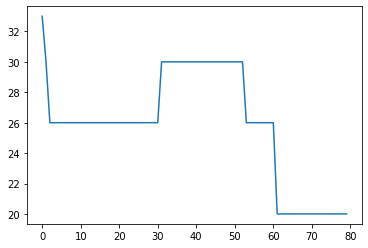

In [15]:
plt.plot(x, y, linestyle="-")